## Importing Libraries

In [83]:
import pandas as pd
import tensorflow as tf
from resnet import ResNet
from data.datasets import load_mnist_dataset
from data.datasets import load_az_dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import build_montages
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns
sns.set(style = "darkgrid")

print("Tensorflow Version = ",tf.__version__)

Tensorflow Version =  2.1.0


## Loadind up data

In [2]:
EPOCHS = 50
INIT_LR = 1e-1
BS = 128
(azData, azLabels) = load_az_dataset('data/a_z_handwritten_data.csv')
(digitsData, digitsLabels) = load_mnist_dataset()

## Data Resizing and conversion

In [3]:
azLabels += 10
data = np.vstack([azData, digitsData])
labels = np.hstack([azLabels, digitsLabels])
data = [cv2.resize(image, (32, 32)) for image in data]
data = np.array(data, dtype="float32")
data = np.expand_dims(data, axis=-1)
data /= 255.0

In [18]:
labels.argmax(axis=1)

array([10, 10, 10, ...,  4,  5,  6], dtype=int64)

In [31]:
unique, counts = np.unique(labels.argmax(axis=1), return_counts=True)

In [61]:
label_counts = np.asarray((unique, counts)).T

<BarContainer object of 36 artists>

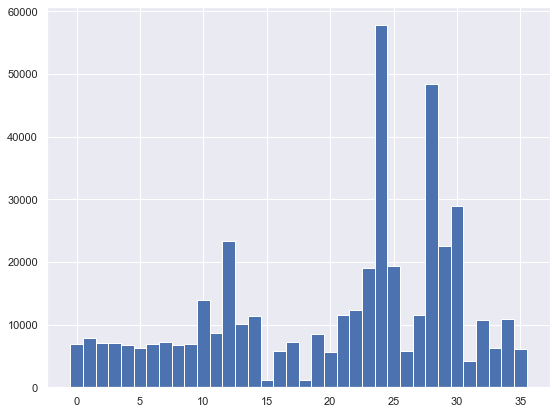

In [80]:
f, ax = plt.subplots(figsize=(9,7))
plt.bar(unique , counts ,width = 1 )

## Spliting data 

In [4]:
le = LabelBinarizer()
labels = le.fit_transform(labels)
counts = labels.sum(axis=0)
classTotals = labels.sum(axis=0)
classWeight = {}
for i in range(0, len(classTotals)):
    classWeight[i] = classTotals.max() / classTotals[i]
(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.20, stratify=labels, random_state=42)

## Data augmentation

In [5]:
# data augmentation
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    fill_mode="nearest")

## Compiling Model

In [6]:
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model = ResNet.build(32, 32, 1, len(le.classes_), (3, 3, 3),(64, 64, 128, 256), reg=0.0005)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

## Training Model

In [7]:
r = model.fit(aug.flow(trainX, trainY, batch_size=BS),validation_data=(testX, testY),steps_per_epoch=len(trainX) // BS,epochs=EPOCHS,class_weight=classWeight,verbose = 2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2765 steps, validate on 88491 samples
Epoch 1/50
2765/2765 - 266s - loss: 1.8996 - accuracy: 0.8679 - val_loss: 1.0922 - val_accuracy: 0.8730
Epoch 2/50
2765/2765 - 264s - loss: 0.9452 - accuracy: 0.9291 - val_loss: 0.8617 - val_accuracy: 0.9193
Epoch 3/50
2765/2765 - 263s - loss: 0.8637 - accuracy: 0.9350 - val_loss: 1.1061 - val_accuracy: 0.8315
Epoch 4/50
2765/2765 - 265s - loss: 0.8209 - accuracy: 0.9374 - val_loss: 0.8897 - val_accuracy: 0.8868
Epoch 5/50
2765/2765 - 268s - loss: 0.7948 - accuracy: 0.9397 - val_loss: 0.8990 - val_accuracy: 0.8753
Epoch 6/50
2765/2765 - 266s - loss: 0.7758 - accuracy: 0.9414 - val_loss: 0.9228 - val_accuracy: 0.8586
Epoch 7/50
2765/2765 - 267s - loss: 0.7600 - accuracy: 0.9424 - val_loss: 0.8393 - val_accuracy: 0.8837
Epoch 8/50
2765/2765 - 262s - loss: 0.7458 - accuracy: 0.9440 - val_loss: 0.8934 - val_accuracy: 0.8645
Epoch 9/50
2765/2765 - 264s - loss: 0.7335 - accuracy: 0.9455 - val_lo

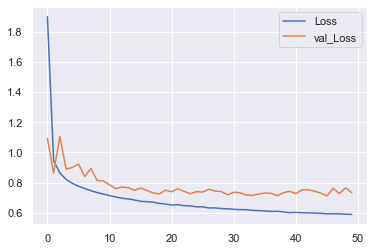

In [14]:
plt.plot(r.history["loss"], label= "Loss")
plt.plot(r.history["val_loss"], label = "val_Loss")
plt.legend();

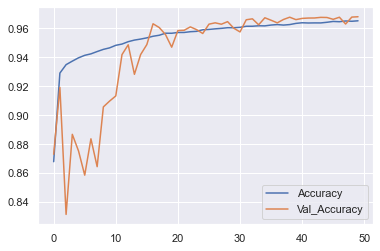

In [15]:
plt.plot(r.history["accuracy"] ,label = "Accuracy")
plt.plot(r.history["val_accuracy"] ,label = "Val_Accuracy")
plt.legend();

<AxesSubplot:>

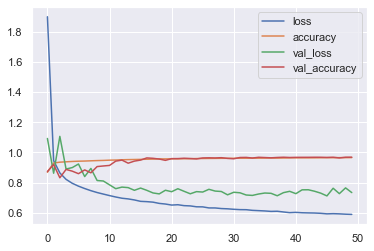

In [16]:
pd.DataFrame(r.history).plot()

In [51]:
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]
preds = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),preds.argmax(axis=1), target_names=labelNames))

              precision    recall  f1-score   support

           0       0.62      0.51      0.56      1381
           1       0.98      0.98      0.98      1575
           2       0.94      0.95      0.94      1398
           3       0.98      0.99      0.99      1428
           4       0.93      0.98      0.95      1365
           5       0.78      0.94      0.85      1263
           6       0.97      0.98      0.97      1375
           7       0.97      0.99      0.98      1459
           8       0.97      0.99      0.98      1365
           9       0.99      0.98      0.99      1392
           A       1.00      0.99      0.99      2774
           B       0.98      0.98      0.98      1734
           C       0.99      0.99      0.99      4682
           D       0.90      0.98      0.94      2027
           E       0.99      0.99      0.99      2288
           F       0.97      0.99      0.98       232
           G       0.97      0.96      0.97      1152
           H       0.98    

## Saving Model

In [52]:
model.save("model.h5")